In [1]:
!pip install git+https://github.com/tachukao/mgplvm-pytorch

  Cloning https://github.com/tachukao/mgplvm-pytorch to /tmp/pip-req-build-q7ffo0xp
  Running command git clone --filter=blob:none --quiet https://github.com/tachukao/mgplvm-pytorch /tmp/pip-req-build-q7ffo0xp
  Resolved https://github.com/tachukao/mgplvm-pytorch to commit 497eac61b39bbb8726b61633f6d0019fb7d21a28
  Preparing metadata (setup.py) ... done
  Created wheel for mGPLVM: filename=mGPLVM-0.0.1-py3-none-any.whl size=71383 sha256=f3c844cec19901cd1fe570f3cd5f598d543fb64e5ccef5f77fc9f6ebc3d65900
  Stored in directory: /tmp/pip-ephem-wheel-cache-9332wzyo/wheels/63/43/f2/8e73c96f0ea9d5fb07c1acd25d6deb7459ff63e81f1c672687
Successfully built mGPLVM


In [2]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.special import gamma, kv
from numpy import matlib

import torch
import mgplvm as mgp
import pickle
import time
from sklearn.decomposition import FactorAnalysis
from sklearn.linear_model import LinearRegression, Ridge
from scipy.interpolate import CubicSpline
from scipy.ndimage import gaussian_filter1d
plt.rcParams['font.size'] = 20
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
np.random.seed(0)
torch.manual_seed(0)
device = mgp.utils.get_device() # use GPU if available, otherwise CPU
print(device)

loading
cpu


In [3]:
def matern_kernel(r, l, nu):
    """
    Matern kernel function
    """
    return (2**(1-nu)/gamma(nu))*((np.sqrt(2*nu)*r)/l)**nu*kv(nu, (np.sqrt(2*nu)*r)/l)

def squared_exponential_kernel(r, l):
    """
    Squared exponential kernel function
    """
    return np.exp(-(r**2)/(2*l**2))

def exponential_kernel(r, l):
    """
    Exponential kernel function
    """
    return np.exp(-r/l)


<ipython-input-3-ccfc1e9c2edc>:5: RuntimeWarning: invalid value encountered in multiply
  return (2**(1-nu)/gamma(nu))*((np.sqrt(2*nu)*r)/l)**nu*kv(nu, (np.sqrt(2*nu)*r)/l)


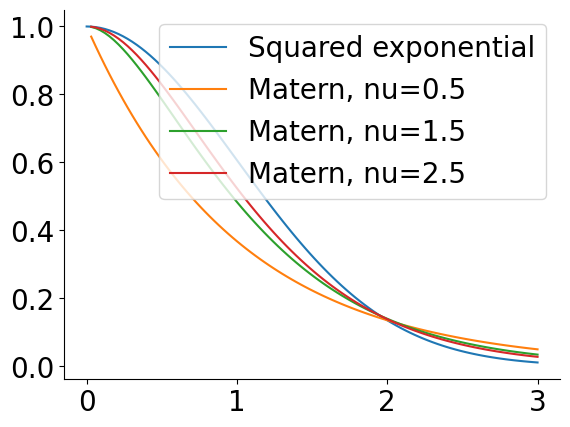

In [4]:
r = np.linspace(0, 3, 100)
l = 1.0
nus = np.array([0.5, 1.5, 2.5])
plt.plot(r, squared_exponential_kernel(r, l), label='Squared exponential')
for nu in nus:
    plt.plot(r, matern_kernel(r, l, nu), label='Matern, nu={}'.format(nu))
plt.legend()
plt.show()

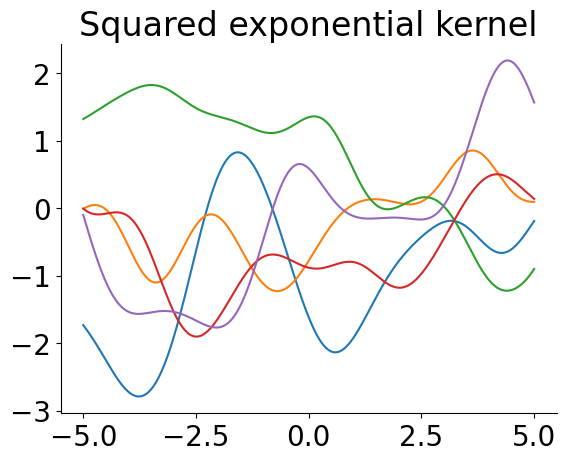

In [5]:
x_axis = np.linspace(-5, 5, 1000)
l = 1.0

K = squared_exponential_kernel(x_axis[:, None] - x_axis[None, :], l)
num_funcs = 5
plt.plot(x_axis, np.random.multivariate_normal(mean=np.zeros(len(x_axis)), cov=K, size=num_funcs).T)
plt.title('Squared exponential kernel')
plt.show()


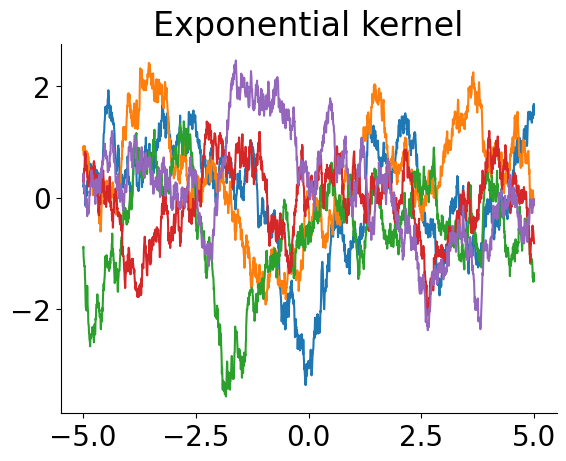

In [6]:
x_axis = np.linspace(-5, 5, 2000)
l = 1.0

K = exponential_kernel(abs(x_axis[:, None] - x_axis[None, :]), 1.0)
num_funcs = 5
plt.plot(x_axis, np.random.multivariate_normal(mean=np.zeros(len(x_axis)), cov=K, size=num_funcs).T)
plt.title('Exponential kernel')
plt.show()

# Task

In [4]:
class SyntheticData:
    def __init__(self, dt=0.02, D=3, ntrials=1, l=0.2, start=0, stop=20, c_mean=0, c_var=1, N=100, var=1):
        self.dt = dt # time step (seconds)
        self.T = int((stop - start) / dt) # number of time steps

        self.D = D # number of latent dimensions
        self.ntrials = ntrials # number of trials
        self.l = l # length scale of kernel (seconds)
        self.start = start # start time
        self.stop = stop # stop time
        self.c_mean = c_mean # mean of C
        self.c_var = c_var # variance of C
        self.N = N # number of neurons
        self.C = self.get_C() # N x D matrix
        self.x_axis = np.linspace(self.start, self.stop, self.T)

        self.Xs = []
        self.Ys = []

        self.var = var # variance of GP kernel

    # Questions:
    # 1. What is the mean of the GP?
    # 2. How to choose range of start and stop values?
    def get_X(self, kernel): # return D x T matrix
        if kernel == 'squared_exponential':
            K = squared_exponential_kernel(self.x_axis[:, None] - self.x_axis[None, :], self.l)
        elif kernel == 'exponential':
            K = exponential_kernel(abs(self.x_axis[:, None] - self.x_axis[None, :]), self.l)
        else:
            raise ValueError("kernel must be 'squared_exponential' or 'exponential'")
        # Check if var used properly!!
        X = np.random.multivariate_normal(mean=np.zeros(len(self.x_axis)), cov=K*self.var, size=(self.ntrials,self.D))
        self.Xs.append(X)
        return self.Xs[-1]

    def get_C(self): # returns N x D matrix
        return np.random.normal(self.c_mean, self.c_var, size=(self.N, self.D))

    def get_Y(self, kernel='squared_exponential'):
        X = self.get_X(kernel)
        F = np.matmul(self.C, X)
        self.Ys.append(np.random.poisson(np.log(1 + np.exp(F))))
        return self.Ys[-1]

    def plot_Y(self, ind=None):
        ### plot the activity we just loaded ###
        for i, Y in enumerate(self.Ys):
            if ind is None or i == ind:
                plt.figure(figsize = (12, 6))
                plt.imshow(Y[0, ...], cmap = 'Greys', aspect = 'auto', vmin = np.quantile(Y, 0.01), vmax = np.quantile(Y, 0.99))
                plt.xlabel('time')
                plt.ylabel('neuron')
                plt.title('Raw activity', fontsize = 25)
                plt.xticks([])
                plt.yticks([])
                plt.show()

    def plot_X(self, ind=None):
        ### plot the activity we just loaded ###
        for i, X in enumerate(self.Xs):
            if ind is None or i == ind:
                for _X in X:
                    plt.plot(self.x_axis, _X.T)
                    plt.show()

In [8]:
s = SyntheticData(var=0.5)
# print(np.shape(s.get_C()))
Y = s.get_Y()
print(np.shape(Y))

Y_e = s.get_Y(kernel='exponential')
print(np.shape(Y_e))

(1, 100, 1000)
(1, 100, 1000)


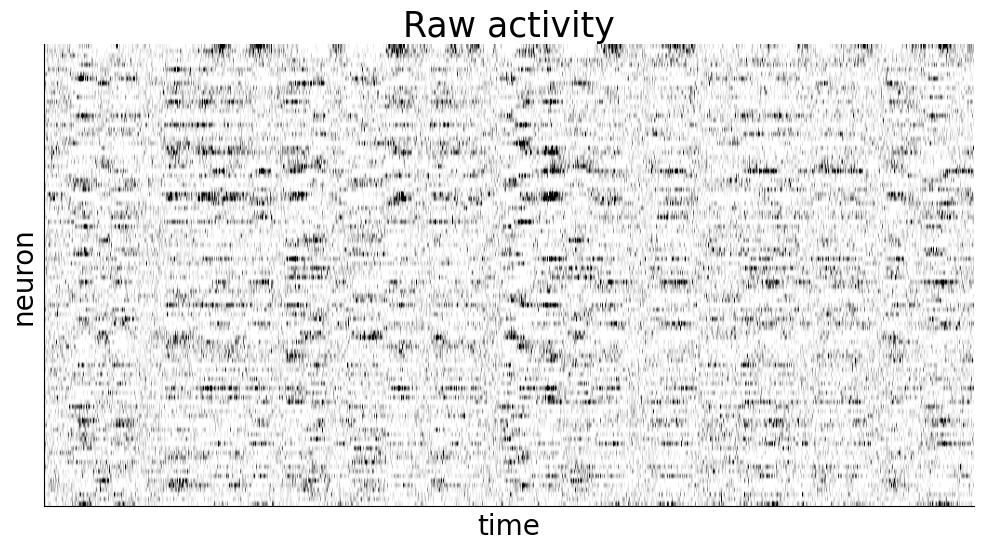

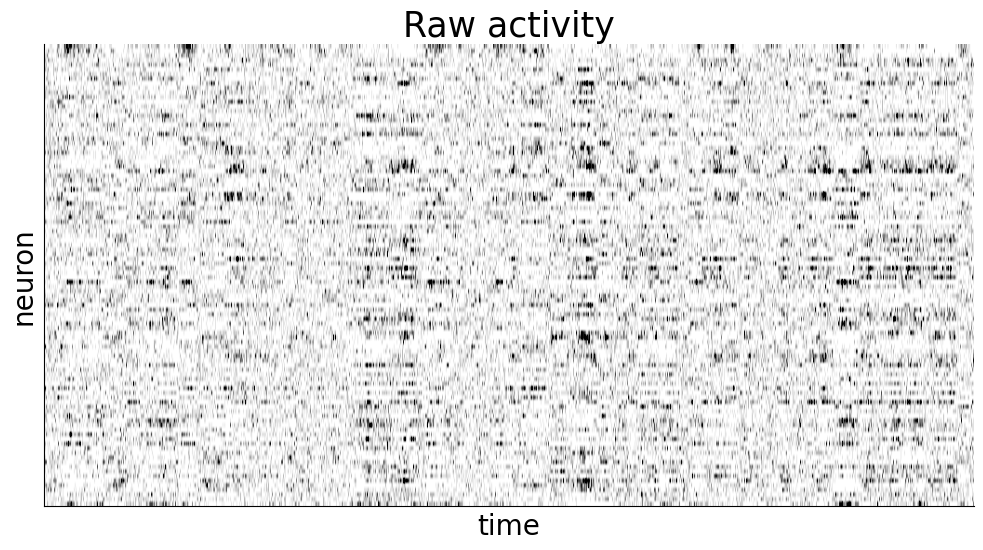

In [9]:
s.plot_Y()

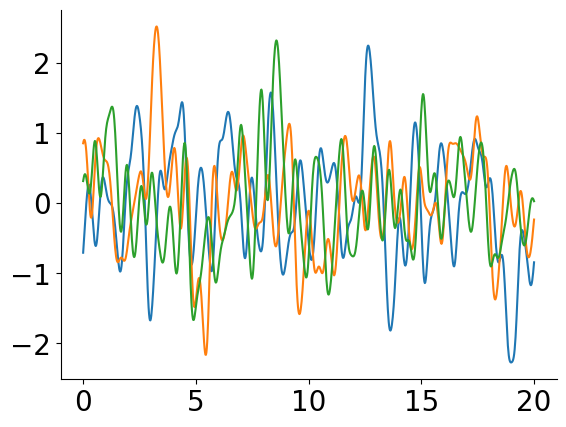

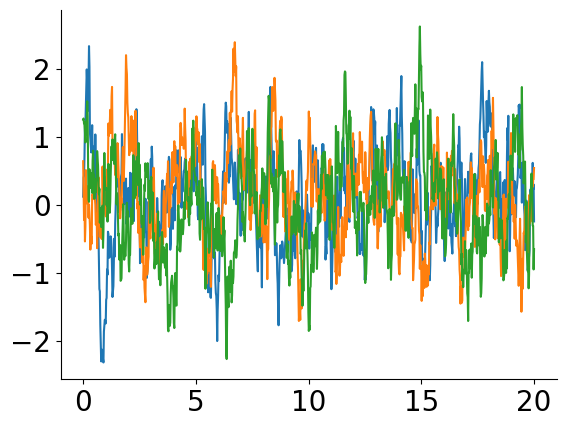

In [10]:
s.plot_X()

In [11]:
'''
What to do with binsize for synthetic data??
'''

def train(Y):
  binsize = s.dt * 1000
  ts = np.arange(s.T)
  fit_ts = torch.tensor(ts)[None, None, :].to(device)
  data = torch.tensor(Y).to(device)

  ### set some parameters for fitting ###
  ell0 = (s.l * 1000)/binsize # initial timescale (in bins) for each dimension. This could be the ~timescale of the behavior of interest (otherwise a few hundred ms is a reasonable default)
  rho = 2 # sets the intial scale of each latent (s_d in Jensen & Kao). rho=1 is a natural choice with Gaussian noise; less obvious with non-Gaussian noise but rho=1-5 works well empirically.
  max_steps = 1001 # number of training iterations
  n_mc = 5 # number of monte carlo samples per iteration
  print_every = 100 # how often we print training progress
  d_fit = 10 # lets fit up to 10 latent dimensions (in theory this could be up to the number of neurons; should be thought of as an upper bound to how high-dimensional the activity is)

  ### construct the actual model ###
  ntrials, n, T = Y.shape # Y should have shape: [number of trials (here 1) x neurons x time points]
  # lik = mgp.likelihoods.NegativeBinomial(n, Y=Y) # we use a negative binomial noise model in this example (recommended for ephys data)
  lik = mgp.likelihoods.Poisson(n)
  manif = mgp.manifolds.Euclid(T, d_fit) # our latent variables live in a Euclidean space for bGPFA (see Jensen et al. 2020 for alternatives)
  var_dist = mgp.rdist.GP_circ(manif, T, ntrials, fit_ts, _scale=1, ell = ell0) # circulant variational GP posterior (c.f. Jensen & Kao et al. 2021)
  lprior = mgp.lpriors.Null(manif) # here the prior is defined implicitly in our variational distribution, but if we wanted to fit e.g. Factor analysis this would be a Gaussian prior
  mod = mgp.models.Lvgplvm(n, T, d_fit, ntrials, var_dist, lprior, lik, Y = Y, learn_scale = False, ard = True, rel_scale = rho).to(device) #create bGPFA model with ARD

    ### training will proceed for 1000 iterations (this takes ~2 minutes) ###
  t0 = time.time()
  def cb(mod, i, loss):
      """here we construct an (optional) function that helps us keep track of the training"""
      if i % print_every == 0:
          sd = np.log(mod.obs.dim_scale.detach().cpu().numpy().flatten())
          print('iter:', i, 'time:', str(round(time.time()-t0))+'s', 'log scales:', np.round(sd[np.argsort(-sd)], 1))

  # helper function to specify training parameters
  train_ps = mgp.crossval.training_params(max_steps = max_steps, n_mc = n_mc, lrate = 7.5e-2, callback = cb, print_every = np.nan)
  print('fitting', n, 'neurons and', T, 'time bins for', max_steps, 'iterations')
  mod_train = mgp.crossval.train_model(mod, data, train_ps)

    ### we start by plotting 'informative' and 'discarded' dimensions ###
  print('plotting informative and discarded dimensions')
  dim_scales = mod.obs.dim_scale.detach().cpu().numpy().flatten() #prior scales (s_d)
  dim_scales = np.log(dim_scales) #take the log of the prior scales
  nus = np.sqrt(np.mean(mod.lat_dist.nu.detach().cpu().numpy()**2, axis = (0, -1))) #magnitude of the variational mean
  plt.figure()
  plt.scatter(dim_scales, nus, c = 'k', marker = 'x', s = 80) #top right corner are informative, lower left discarded
  plt.xlabel(r'$\log \, s_d$')
  plt.ylabel('latent mean scale', labelpad = 5)
  plt.show()


fitting 100 neurons and 1000 time bins for 1001 iterations
iter: 0 time: 3s log scales: [-0.1 -0.2 -0.5 -1.2 -1.4 -1.7 -1.8 -1.8 -1.9 -2. ]
iter: 100 time: 8s log scales: [-0.1 -0.2 -0.5 -1.2 -1.4 -1.7 -1.8 -1.9 -1.9 -2. ]
iter: 200 time: 12s log scales: [-0.5 -0.6 -0.8 -1.5 -1.5 -1.6 -1.7 -1.9 -2.2 -2.3]
iter: 300 time: 16s log scales: [-0.8 -0.8 -1.1 -1.6 -1.8 -1.9 -1.9 -2.  -2.3 -2.4]
iter: 400 time: 20s log scales: [-1.3 -1.3 -1.6 -2.2 -2.2 -2.4 -2.6 -2.6 -2.9 -3.1]
iter: 500 time: 24s log scales: [-1.3 -1.3 -1.6 -2.2 -2.2 -2.4 -2.6 -2.6 -2.9 -3.1]
iter: 600 time: 28s log scales: [-1.3 -1.3 -1.6 -2.2 -2.2 -2.4 -2.6 -2.6 -2.9 -3.1]
iter: 700 time: 32s log scales: [-1.3 -1.3 -1.6 -2.2 -2.2 -2.4 -2.6 -2.6 -2.9 -3.1]
iter: 800 time: 36s log scales: [-1.3 -1.3 -1.6 -2.2 -2.2 -2.4 -2.6 -2.6 -2.9 -3.1]
iter: 900 time: 40s log scales: [-1.3 -1.3 -1.6 -2.2 -2.2 -2.4 -2.6 -2.6 -2.9 -3.1]
iter: 1000 time: 44s log scales: [-1.3 -1.3 -1.6 -2.2 -2.2 -2.4 -2.6 -2.6 -2.9 -3.1]
plotting informative

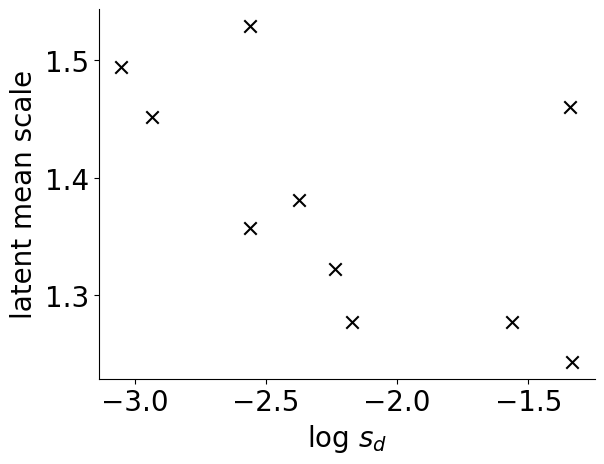

In [12]:
train(Y)

fitting 100 neurons and 1000 time bins for 1001 iterations
iter: 0 time: 0s log scales: [-0.2 -0.4 -0.5 -1.2 -1.5 -1.6 -1.7 -1.9 -1.9 -2. ]
iter: 100 time: 4s log scales: [-0.2 -0.4 -0.5 -1.2 -1.6 -1.7 -1.7 -1.9 -2.  -2.1]
iter: 200 time: 8s log scales: [-0.3 -0.4 -0.5 -1.3 -1.6 -1.8 -1.8 -2.  -2.  -2.2]
iter: 300 time: 12s log scales: [-0.3 -0.4 -0.5 -1.3 -1.6 -1.8 -1.8 -2.  -2.  -2.2]
iter: 400 time: 17s log scales: [-0.3 -0.4 -0.5 -1.3 -1.6 -1.8 -1.8 -2.  -2.  -2.2]
iter: 500 time: 21s log scales: [-0.3 -0.4 -0.5 -1.3 -1.6 -1.8 -1.8 -2.  -2.  -2.2]
iter: 600 time: 25s log scales: [-0.3 -0.4 -0.5 -1.3 -1.6 -1.8 -1.8 -2.  -2.  -2.2]
iter: 700 time: 29s log scales: [-0.3 -0.4 -0.5 -1.3 -1.6 -1.8 -1.8 -2.  -2.  -2.2]
iter: 800 time: 33s log scales: [-0.8 -2.1 -2.3 -2.7 -3.  -3.2 -3.3 -3.4 -3.7 -4. ]
iter: 900 time: 37s log scales: [-0.8 -2.1 -2.3 -2.7 -3.  -3.2 -3.3 -3.4 -3.7 -4. ]
iter: 1000 time: 41s log scales: [-0.8 -2.1 -2.3 -2.7 -3.  -3.2 -3.3 -3.4 -3.7 -4. ]
plotting informative 

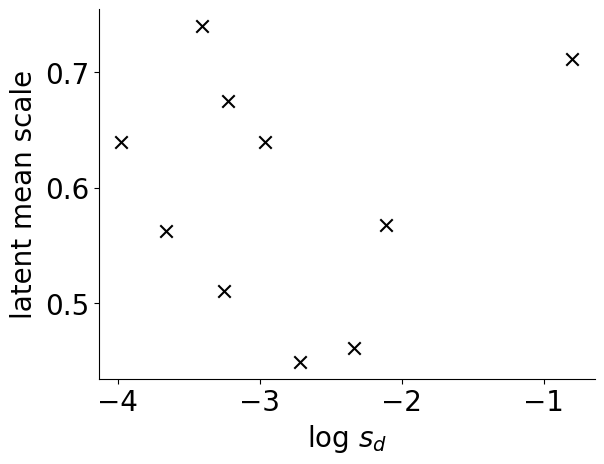

In [13]:
train(Y_e)

In [7]:
rates = np.zeros(s.N)
for i in range(s.N):
    rates[i] = np.sum(s.Ys[0][0,i]) / s.stop
print(np.average(rates))

34.842499999999994


In [15]:
a = 5
A = np.random.multivariate_normal(mean=np.zeros(a), cov=np.eye(a), size=(1,3))
A.shape
# np.matmul(np.eye(3), A) - A

(1, 3, 5)

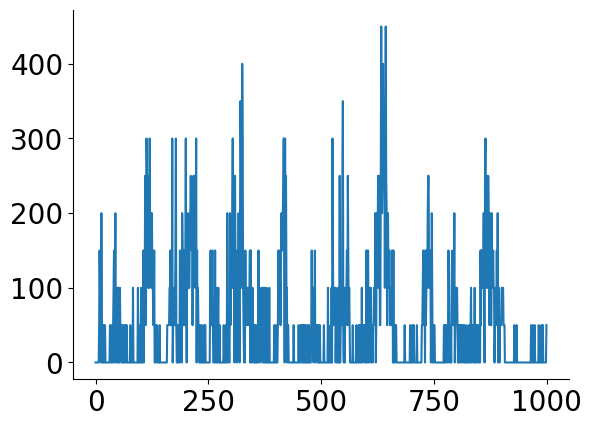

In [16]:
plt.plot(Y[0][0].T/s.dt)